In [7]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../')

# We import the base of the model
import boario.simulation as sim
# We also import the indicators module
from boario.indicators import Indicators
import pathlib
import numpy as np
import pandas as pd

base_time = 2

# We instantiate a dictionary with the parameters
# (it is also possible to use a json file)
params = {
    # The name of the working directory to use (relative to current wd)
    "input_dir": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/",
    "output_dir": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/",
    # The directory to use to store results (relative to storage_dir)
    # i.e. here, the model will look for files in ~/boario/storage/ and
    # store results in ~/boario/storage/results/
    "results_storage": "results",
    # This tells the model to register the evolution of the stocks
    # of every industry (the file can be quite large (2Gbytes+ for
    # a 365 days simulation with exiobase))
    "register_stocks": False,
    # Parameters of the model (we detail these in the documentation)
   "psi_param": 0.99999,
   "model_time_step": base_time,
   "timestep_dividing_factor": 365,
   "inventory_restoration_time": 30,
   "alpha_base": 1.0,
   "alpha_max": 1.25,
   "alpha_tau": 365,
   "rebuild_tau": 60,
   "n_timesteps": 730,
   "min_duration": 730,
   "impacted_region_base_production_toward_rebuilding": 0.0000000001,
   "row_base_production_toward_rebuilding": 0.0,
    "mrio_params_file": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/mrio_params.json"
}

# Here we define the event perturbing the simulation
event = {
    # The list of affected regions (their index in the mrio table)
    # Here we just have France
    "aff-regions": ["DE"],
    # The list of affected sectors
    # (here we specify that all sectors are impacted)
    "aff-sectors": 'all',
    # The shares of the damages distributed between regions
    # (1 as we have only one region)
    "dmg-distrib-regions": [ 1 ],
    # The type of distribution of damages for the sectors
    # (more on that in the doc)
    "dmg-distrib-sectors-type": "gdp",
    # 'gdp' distribution doesn't require this parameter to be set
    "dmg-distrib-sectors": [],
    # The duration of the event (not implemented yet, so it has no effect)
    "duration": 28,
    # A name for the event (usefull when simulating multiple events)
    "name": "0",
    # The step at which the event shall occur during the simulation
    "occur": 7,
    # The quantity of damages caused by the event (in IO table monetary)
    "q_dmg":1000000000,
    # The sectors mobilised to answer the rebuilding demand
    # and the share of the demand they answer
    "rebuilding-sectors": {
        "Public administration and defence; compulsory social security, Education and Health (75,80,85)": 0.24,
        "Construction (45)": 0.24,
        "Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)": 0.05,
        "Manufacture of construction products and cement": 0.05,
        "Manufacture of office machinery and computers (30)": 0.023,
        "Other land transport": 0.046,
        "Manufacture of electrical machinery and apparatus n.e.c. (31)": 0.08,
        "Financial intermediation, insurance and pension funding (65)": 0.024,
        "Manufacture of furniture; manufacturing n.e.c. (36)": 0.06,
        "Manufacture of textile and wearing apparel (17,18)": 0.011,
        "Manufacture of machinery and equipment n.e.c. (29)": 0.01,
        "Chemicals nec": 0.005,
        "Retail sale of automotive fuel": 0.005,
        "Processing of food products nec": 0.003,
        "Manufacture of ceramic goods": 0.0009,
        "Manufacture of medical, precision and optical instruments, watches and clocks (33)": 0.002,
        "Cultivation in general": 5e-05,
        "Animal farming": 5e-05,
        "Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries": 0.05,
        "Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)": 0.05,
        "Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)": 0.05
    }
}


# We load the mrio table from a pickle file (created with the help of the
# pymrio module, more on that in the doc)
mrio_path = pathlib.Path("/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/mrio_full.pkl")

In [8]:
prod_dic = {}
for base_time in [1,7]:
        # We initiate a model instance ...
    params['model_time_step'] = base_time
    event['duration'] = int(10)
    model = sim.Simulation(params, mrio_path)
    #model_2 = sim.Simulation(params_2, mrio_path_2)
    # ... add the list of events (just one here) to the model ...
    model.read_events_from_list([event])

    # ... and launch the simulation with :
    model.loop()

    # ... add the list of events (just one here) to the model ...
    #model_2.read_events_from_list([event_2])

    # ... and launch the simulation with :
    #model_2.loop()

    # Once the simulation is over we can compute some indicators :
    indic = Indicators.from_folder(
                                   pathlib.Path(params['output_dir'])/"results",
                                   indexes_file=pathlib.Path(params['output_dir'])/"results"/"indexes.json",
                                    include_crash=True
    )
    prod_dic[base_time] = indic.prod_df #- indic.prodmax_df).round(6)
    
prod_df_all = pd.concat(prod_dic.values(), axis=1, keys=prod_dic.keys())
prod_df_all = prod_df_all.replace(-9.0,np.nan)#.loc[~(prod_df_all==-9.).all(axis=1)]
prod_df_all.columns = prod_df_all.columns.rename('base_time',level=0)
#ovr_df_all = pd.concat(ovr_dic.values(), axis=1, keys=ovr_dic.keys())
#ovr_df_all = ovr_df_all.replace(-9.0,np.nan)#.loc[~(r_dem_df_all==-9.).all(axis=1)]
#ovr_df_all.columns = ovr_df_all.columns.rename('base_time',level=0)
#r_dem_df_all = pd.concat(r_dem_dic.values(), axis=1, keys=r_dem_dic.keys())
#r_dem_df_all = r_dem_df_all.replace(-9.0,np.nan)#.loc[~(c_dem_df_all==-9.).all(axis=1)]
#r_dem_df_all.columns = r_dem_df_all.columns.rename('base_time',level=0)
#loss_df_all = pd.concat(loss_dic.values(), axis=0, keys=loss_dic.keys())
#loss_df_all = loss_df_all.loc[~(loss_df_all==-9.).all(axis=1)]
#loss_df_all = loss_df_all.rename_axis(['base_time','index'])

16:05:14 [INFO] - [simulation.py > __init__() > 57] - Initializing new simulation instance
16:05:14 [DEBUG] - [mriosystem.py > __init__() > 146] - Initiating new MrioSystem instance
16:05:14 [INFO] - [mriosystem.py > __init__() > 152] - Results storage is: /home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/results
16:05:14 [INFO] - [mriosystem.py > __init__() > 167] - Monetary unit is: 1000000
16:05:15 [INFO] - [simulation.py > __init__() > 130] - Initialized !
16:05:15 [INFO] - [simulation.py > read_events_from_list() > 323] - Reading events from given list and adding them to the model
16:05:15 [INFO] - [simulation.py > loop() > 153] - Starting model loop for at most 730 steps
16:05:15 [INFO] - [simulation.py > loop() > 154] - One step is 1 day(s)
16:05:15 [INFO] - [simulation.py > loop() > 159] - Parameters : 
 {
    "input_dir": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/",
    "output_dir": "/home/sjuhel/Nextcloud/Thesis/Workbench/Data/BoARIO-testing/",
 

In [9]:
rebuild_sect = [
    "Public administration and defence; compulsory social security, Education and Health (75,80,85)",
        "Construction (45)",
        "Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials (20)",
        "Manufacture of construction products and cement",
        "Manufacture of office machinery and computers (30)",
        "Other land transport",
        "Manufacture of electrical machinery and apparatus n.e.c. (31)",
        "Financial intermediation, insurance and pension funding (65)",
        "Manufacture of furniture; manufacturing n.e.c. (36)",
        "Manufacture of textile and wearing apparel (17,18)",
        "Manufacture of machinery and equipment n.e.c. (29)",
        "Chemicals nec",
        "Retail sale of automotive fuel",
        "Processing of food products nec",
        "Manufacture of ceramic goods",
        "Manufacture of medical, precision and optical instruments, watches and clocks (33)",
        "Cultivation in general",
        "Animal farming",
        "Sale, maintenance, repair of motor vehicles, motor vehicles parts, motorcycles, motor cycles parts and accessoiries",
        "Retail trade, except of motor vehicles and motorcycles; repair of personal and household goods (52)",
        "Wholesale trade and commission trade, except of motor vehicles and motorcycles (51)"
]

non_rebuild_sect = [s for s in model.mrio.sectors if s not in rebuild_sect]

prod_df_all_rebuild = prod_df_all.T.loc[(slice(None),slice(None),rebuild_sect),:].groupby(["base_time","region"],axis=0).sum(min_count=1).T
prod_df_all_non_rebuild = prod_df_all.T.loc[(slice(None),slice(None),non_rebuild_sect),:].groupby(["base_time","region"],axis=0).sum(min_count=1).T
prod_df_all_agg = pd.concat([prod_df_all_rebuild,prod_df_all_non_rebuild], axis=1, keys=["Rebuild", "Non rebuild"])
prod_df_all_agg.columns = prod_df_all_agg.columns.rename('sector',level=0)
prod_df_all_agg = prod_df_all_agg.interpolate()

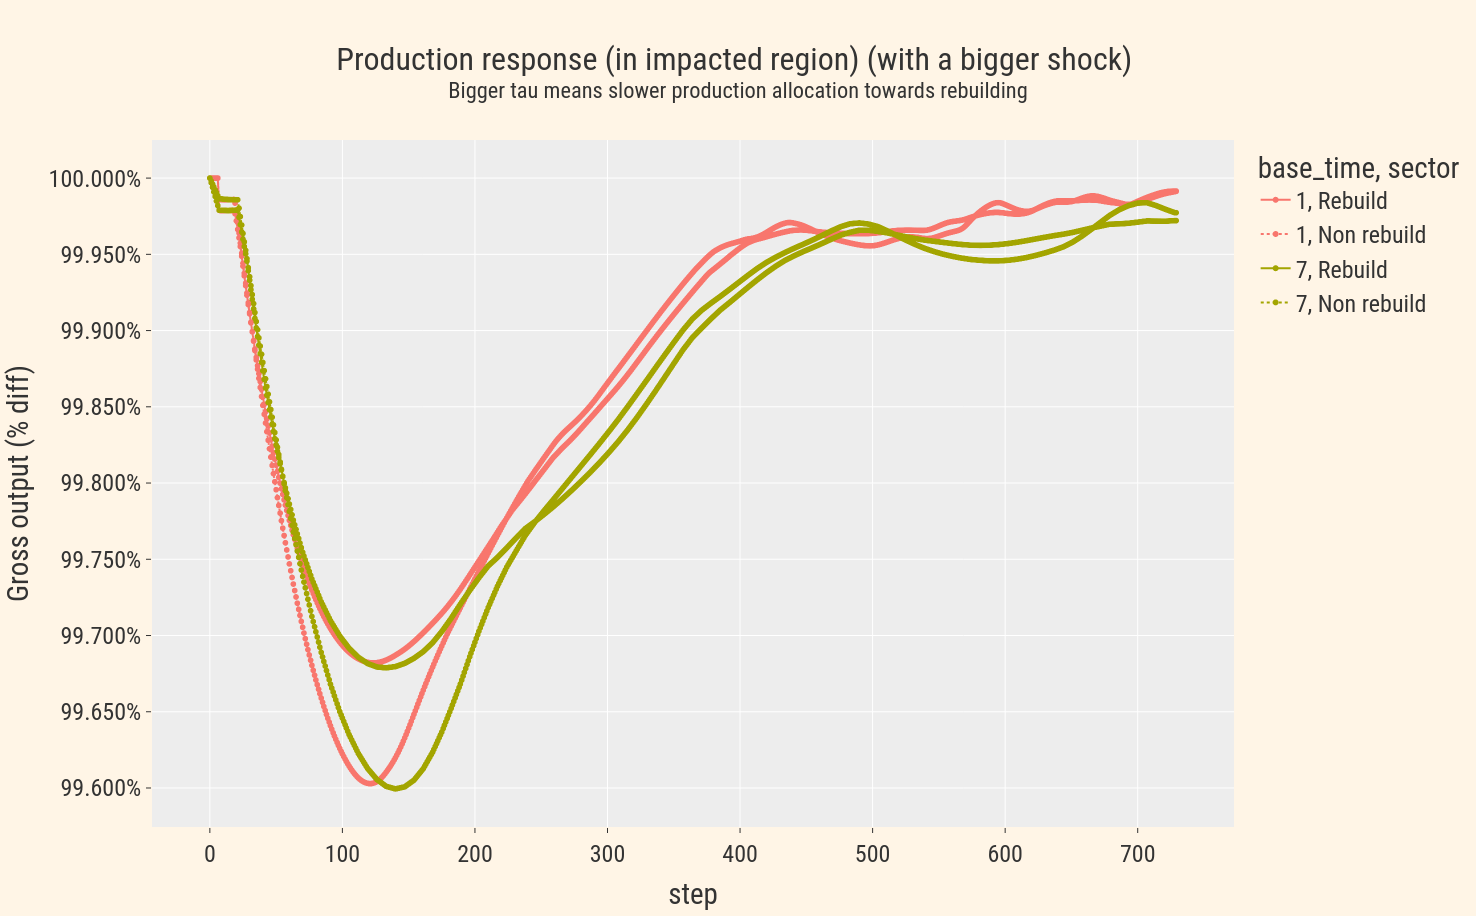

In [10]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates["econ"] = go.layout.Template(
layout = {
    # Fonts
    # Note - 'family' must be a single string, NOT a list or dict!
    'title':
        {'font': {'family': 'Roboto Condensed, bold', 
                  'size':32,
                  'color': '#333'}
        },
    'font': {'family': 'Roboto Condensed', 
                  'size':24,
                  'color': '#333'},
    # Colorways
    #'colorway': ['#ec7424', '#a4abab'],
    # Keep adding others as needed below
    'margin': {'l':20, 'r':20, 't':140, 'b':20},
    'paper_bgcolor':"#fff5e6",
    'width':1600,
    'height':1800,
    },
)
pio.templates["econ"].layout.autosize = False
px.defaults.template = "ggplot2+econ"

prod_pct_df = prod_df_all_agg.copy()
#prod_pct_df = prod_df_all.copy()
#prod_pct_df=prod_pct_df.dropna(how='any',axis=0)
prod_pct_df = prod_pct_df / prod_pct_df.loc[0,:]
#prod_pct_df = prod_pct_df.add(1)
#prod_pct_df = prod_pct_df.pct_change()
#prod_pct_df = prod_pct_df.fillna(0)
#prod_pct_df = prod_pct_df.add(1)
#prod_pct_df = prod_pct_df.cumprod()
#prod_pct_df = prod_pct_df.sub(1)
#prod_pct_df = prod_pct_df.cumsum()

prod_pct_df = prod_pct_df.loc[:,pd.IndexSlice[:,:,'DE']]
df = prod_pct_df.reset_index().melt(id_vars="step")

df = df.rename(columns={"value":"Gross output (% diff)"})

fig = px.line(df, color="base_time", y="Gross output (% diff)", line_dash="sector", x="step", markers=True)

fig.update_layout(height=900,
                  title = "Production response (in impacted region) (with a bigger shock) <br><sup>Bigger tau means slower production allocation towards rebuilding</sup>",
                  yaxis_tickformat=".3%",
                 )

fig.show()